<p align="left">
  <a href="https://colab.research.google.com/github/fernandoarcevega/AI_Workshop/blob/main/Part_1/04_Logistic_regression/04_logreg_mnl.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200">
  </a>
</p>

In [ ]:
###############################################
# Author 1: Wilfrido Gómez-Flores (CINVESTAV) #
# Author 2: Fernando Arce-Vega (CIO)          #
# e-mail 1: wilfrido.gomez@cinvestav.mx       #
# e-mail 2: farce@cio.mx                      #
# Date:     nov/03/2025                       #
# Subject:  Logistic regression               #
###############################################

In [ ]:
# Libraries
import numpy as np                                                    # Numerical array operations
import pandas as pd                                                   # Data manipulation/analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Model evaluation
import matplotlib.pyplot as plt                                       # Data plotting/visualization

In [ ]:
# Other functions
!wget -q https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/helpers/misc.py
from misc import *

In [ ]:
# Load dataset
# Path to dataset
path = 'https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/datasets/bus_data.csv'
T = pd.read_csv(path)
data = T.values
n, d = data.shape
X = data[:, :d-1]  # Features
Y = data[:, d-1]   # Class labels

In [ ]:
# Check feature and targets shapes
print(f'Features shape: {X.shape}')
print(f'Targets shape:  {Y.shape}')

Features shape: (3287, 19)
Targets shape:  (3287,)


 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵  (Total data)

 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟡 🟡  (Training and testing data)

In [ ]:
# Split dataset into training and test sets (80%-20%)
tr, tt = HoldOut(Y, 0.2)

# Training set
Xtr = X[tr, :]
Ytr = Y[tr]

# Test set
Xtt = X[tt, :]
Ytt = Y[tt]

In [ ]:
# Check feature and targets shapes for training and test sets
print(f'Training features shape: {Xtr.shape}')
print(f'Training targets shape:  {Ytr.shape} \n')
print(f'Testing features shape:  {Xtt.shape}')
print(f'Testing targets shape:   {Ytt.shape}')

Training features shape: (2630, 19)
Training targets shape:  (2630,) 

Testing features shape:  (657, 19)
Testing targets shape:   (657,)


In [ ]:
# Data normalization
Xtr, stats = zscorenorm(Xtr)
Xtt = zscorenorm(Xtt, stats)

In [ ]:
# Main logistic regression
def LRtrain(X, Y, eta, tmax):
    c = np.unique(Y)
    nc = len(c)
    n = X.shape[0]
    X = np.hstack((np.ones((n, 1)), X))     # Augments for bias

    if nc > 2:
        T = np.zeros((n, nc))

        for i in range(nc):
            T[Y == c[i], i] = 1             # One-hot encoding

        W, L = trainMclass(X, T, eta, tmax) # Softmax regression

    else:
        W, L = train2class(X, Y, eta, tmax) # Logistic regression

    return W, L

Logistic regression: **two-class case**

The posterior probability $\hat{y} \equiv p(y = 1|\mathbf{x})$ is given by

$$
\begin{align*}
\hat{y} &= \sigma(\mathbf{x}\mathbf{w}^T), \\
&= \frac{1}{1 + \exp(-\mathbf{x}\mathbf{w}^T)}
\end{align*}
$$

Furthermore, given a training dataset $\{\mathbf{x}_i, y_i\}_{i=1}^n$, where $y_i \in \{0, 1\}$, learning a logistic regression model implies minimizing the **binary cross-entropy** loss:

$$ J(\mathbf{w}) = - \sum_{i=1}^{n} \left[y_i \ln \hat{y}_i + (1 - y_i) \ln(1 - \hat{y}_i)\right]. $$

**Training algorithm**:
$$
\begin{align*}
& \textbf{input:} \quad X, y, \eta, t_{\max} \\
\\
1: \quad & \mathbf{w} \leftarrow \mathbf{0} \\
2: \quad & \textbf{for } t \leftarrow 1 \textbf{ to } t_{\max} \textbf{ do} \\
3: \quad & \qquad \hat{y} \leftarrow \sigma(X\mathbf{w}^T) \\
4: \quad & \qquad \mathbf{w} \leftarrow \mathbf{w} - \eta(\hat{y} - y)^T X \\
\\
& \textbf{return:} \quad \mathbf{w}
\end{align*}
$$

In [ ]:
# Train two-class logistic regression
def train2class(X, T, eta, tmax):
    d = X.shape[1]    # Number of features
    W = np.zeros(d)   # Weight vector
    loss = np.zeros(tmax)

    for t in range(tmax):             # Gradient descent loop
        P = 1 / (1 + np.exp(-X @ W))  # Sigmoid function
        W -= eta * (P - T) @ X        # Update weights

        # Binary cross-entropy loss
        loss[t] = -np.mean(T * np.log(P) + (1 - T) * np.log(1 - P))

    return W, loss

Logistic regression: **multi-class case**

The multi-class case extends the sigmoid function to estimate the posterior probability $\hat{y}_j \equiv p(y=j|\mathbf{x})$ using the **softmax function**:

$$ \hat{y}_j = \frac{\exp(\mathbf{x}\mathbf{w}_j^T)}{\sum_{l=1}^{c} \exp(\mathbf{x}\mathbf{w}_l^T)}, \quad \text{for } j = 1, 2, \dots, c, $$

where $\mathbf{w}_j$ is the weight vector for the jth class. This function satisfies $\sum_{j=1}^{c} \hat{y}_j = 1$.

Furthermore, given a training dataset $\{\mathbf{x}_i, y_i\}_{i=1}^n$, where $y_i \in \{1, 2, \dots, c\}$, learning a softmax regression model implies minimizing the **categorical cross-entropy** loss:

$$ J(\mathbf{w}_1, \dots, \mathbf{w}_c) = - \sum_{i=1}^{n} \sum_{j=1}^{c} y_{ij} \ln \hat{y}_{ij}, \quad \text{with} \quad y_{ij} = \begin{cases} 1 & \text{if } \mathbf{x}_i \in \omega_j, \\ 0 & \text{otherwise,} \end{cases}$$

where the true class label $y_{ij}$ is converted to a binary vector by **one-hot encoding**.

In [ ]:
# Train multiclass logistic regression
def trainMclass(X, T, eta, tmax):
    d = X.shape[1]        # Number of features
    c = T.shape[1]        # Number of classes
    W = np.zeros((c, d))  # Weight matrix
    loss = np.zeros(tmax)

    # Gradient descent loop
    for t in range(tmax):
        E = np.exp(X @ W.T)
        P = E / np.sum(E, axis=1, keepdims=True)  # Softmax
        W -= eta * (P - T).T @ X                  # Update weights

        # Categorical cross-entropy loss
        loss[t] = -np.mean(T * np.log(P))
    return W, loss

In [ ]:
# Predict with the trained linear model
def LRpredict(X, W):
    n = X.shape[0]
    X = np.hstack((np.ones((n, 1)), X))   # Augmented

    if W.ndim > 1:
        E = np.exp(X @ W.T)
        Pr = E / np.sum(E, axis=1, keepdims=True) # Softmax
        Ypp = np.argmax(Pr, axis=1)               # Classify
        Ypp = Ypp+1

    else:
        Pr = 1 / (1 + np.exp(-X @ W))   # Sigmoid
        Ypp = (Pr > 0.5).astype(float)  # Classify

    return Ypp, Pr

In [ ]:
# Train model
eta = 1e-6
tmax = 5000
W, L = LRtrain(Xtr, Ytr, eta, tmax)

In [ ]:
# Classify test data
Ypp, _ = LRpredict(Xtt, W)

In [ ]:
# Print classification error
err = np.mean(Ypp != Ytt)
print(f'Error: {100 * err:.3f}%')

Error: 15.221%


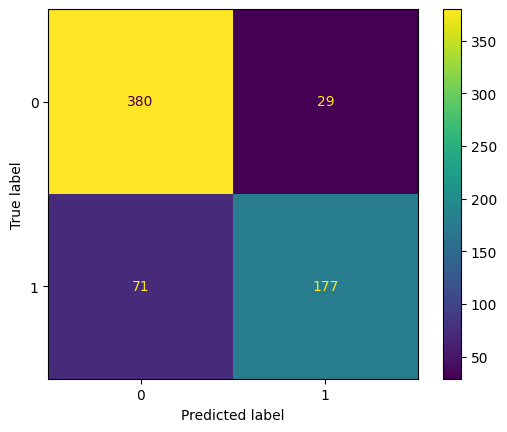

In [ ]:
# Confusion matrix
cm = confusion_matrix(Ytt, Ypp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

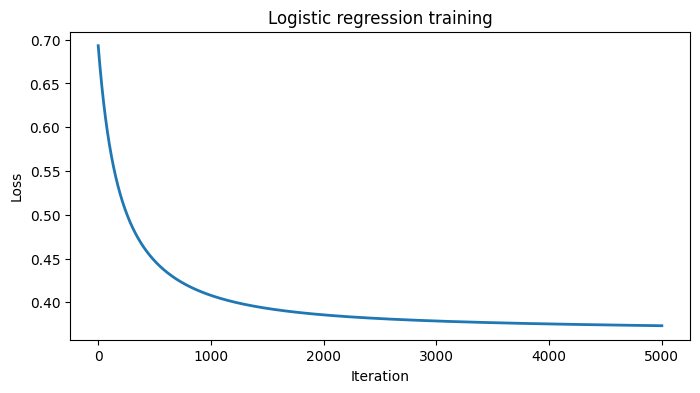

In [ ]:
# Plot training performance of LG
plt.figure(figsize=(8, 4), facecolor='w')
plt.plot(range(1, tmax + 1), L, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic regression training')
plt.show()